# アクセスログの分析
学生番号:21060009  
名前:坂島悠太  
## 目的
　いただいたアクセスログのサイトの性質と、サイトを利用するユーザーの性質を導き出したいと思います。
## 背景
　サイトの性質とユーザーの性質がわかれば、これからどのような判断を行うべきかの判断材料になると思います。
## 分析
　イランのeコマースサイトzanbil.irからの3.3GBのアクセスログを解析し、ユーザーの動向を調査しました。
### 前処理
　アパッチのアクセスログをcsv形式に変換し、access.csvとして保存します。  
※このコードは/data/access.csvが存在しないない場合度だけ実行してください

In [ ]:
# データ前処理

import csv
import re

def parse_log_line(line):
    pattern = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - \[(.*?)\] "(.*?)" (\d{3}) (\d+) "(.*?)" "(.*?)"'
    match = re.match(pattern, line)
    if match:
        return match.groups()
    return None

def convert_log_to_csv(log_file_path, csv_file_path):
    with open(log_file_path, 'r') as log_file, open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['IP', 'DateTime', 'Request', 'Status', 'Bytes', 'Referer', 'UserAgent'])
        for line in log_file:
            parsed_line = parse_log_line(line)
            if parsed_line:
                writer.writerow(parsed_line)

# 使用例
convert_log_to_csv('./data/access.log', './data/access.csv')


#### データの読み込み
先ほど作成した./data/access.csvをdataframeに読み込みます

In [2]:
import pandas as pd

# CSVファイルのパス
csv_file_path = './data/access.csv'

# CSVファイルを読み込む
df = pd.read_csv(csv_file_path)

# DataFrameを表示する
print(df.head(5))


              IP                    DateTime  \
0   54.36.149.41  22/Jan/2019:03:56:14 +0330   
1    31.56.96.51  22/Jan/2019:03:56:16 +0330   
2    31.56.96.51  22/Jan/2019:03:56:16 +0330   
3  40.77.167.129  22/Jan/2019:03:56:17 +0330   
4    91.99.72.15  22/Jan/2019:03:56:17 +0330   

                                             Request  Status  Bytes  \
0  GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...     200  30577   
1     GET /image/60844/productModel/200x200 HTTP/1.1     200   5667   
2     GET /image/61474/productModel/200x200 HTTP/1.1     200   5379   
3     GET /image/14925/productModel/100x100 HTTP/1.1     200   1696   
4  GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...     200  41483   

                               Referer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://www.zanbil.ir/m/filter/b113   
3                                    -   
4                                    -   

                               

#### ランキング用のデータ処理
ランキングを作成するために、データをフィルタリングします

In [17]:
from urllib.parse import urlparse
# urlに指定された文字列を含んでいるかどうか判定する関数
def filter_str(str1:str):
    try:
        str1=str1.lower()
        if (not ('zanbil.ir' in str1)) and (not ('znbl.ir' in str1))and (not ('zanbil-ir' in str1)):
            return str1
        else:
            return '-'
    except Exception as e:
        return '-'
# URLからドメイン名を抽出する関数
def get_domain(url):
    try:
        domain = urlparse(url).netloc
        return domain
    except Exception as e:
        return None
# リファラが空白でないデータをフィルタリング
df_filtered = df[df['Referer'] != '-']
# ドメインがzanbil.irのものだけをフィルタリング
df_filtered['Referer_not_Zanbil']=df_filtered[df_filtered['Referer'].apply(filter_str)!='-']['Referer']
# df_filtered['Referer_Zanbil'] = df_filtered['www.zanbil.ir' in df_filtered['Referer'] is str ]
# リファラからドメイン名を抽出
df_filtered['Referer_Domain'] = df_filtered['Referer_not_Zanbil'].apply(get_domain)


# リファラの頻度を計算
#value_countsメソッドは、デフォルトで出現頻度の降順（最も頻繁に出現する値から最も少なく出現する値まで）でソートされたシリーズを返します
referer_counts = df_filtered['Referer'].value_counts()
referer_not_zanbil_counts = df_filtered['Referer_not_Zanbil'].value_counts()
referer_domain_counts=df_filtered['Referer_Domain'].value_counts()
print(len(referer_counts))
print(len(referer_not_zanbil_counts))
print(len(referer_domain_counts))

C:\Users\spyk4\AppData\Local\Temp\ipykernel_14888\2564014119.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Referer_not_Zanbil']=df_filtered[df_filtered['Referer'].apply(filter_str)!='-']['Referer']
C:\Users\spyk4\AppData\Local\Temp\ipykernel_14888\2564014119.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Referer_Domain'] = df_filtered['Referer_not_Zanbil'].apply(get_domain)


63003
14303
267


### 訪問者数
このサイトにどのくらいのユーザーが訪れたのかをユニーク、総計の2種類導きます。


In [4]:

unique_users = df['IP'].nunique()
total_users = len(df)
print(unique_users, total_users)


127233 5166102


### ページビューランキング
ページごとに閲覧回数が多いものをランキング
※ただし、ファビコンなどのスタティックな要素を除き、/browseというパス以下のパスのみにフィルタしました

Request
GET /m/browse/refrigerator-and-freezer/%DB%8C%D8%AE%DA%86%D8%A7%D9%84-%D9%81%D8%B1%DB%8C%D8%B2%D8%B1 HTTP/1.1                                             2058
GET /m/browse/cell-phone/%DA%AF%D9%88%D8%B4%DB%8C-%D9%85%D9%88%D8%A8%D8%A7%DB%8C%D9%84 HTTP/1.1                                                           1828
GET /m/browse/home-appliances/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C HTTP/1.1                                                      1826
GET /browse/home-appliances/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C HTTP/1.1                                                        1679
GET /m/browse/tv/%D8%AA%D9%84%D9%88%DB%8C%D8%B2%DB%8C%D9%88%D9%86 HTTP/1.1                                                                                1482
GET /m/browse/washing-machine/%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%D9%84%D8%A8%D8%A7%D8%B3%D8%B4%D9%88%DB%8C%DB%8C HTTP/1.1                                    1251
GET /m/browse/stove-and-oven/%D8%A7%D8

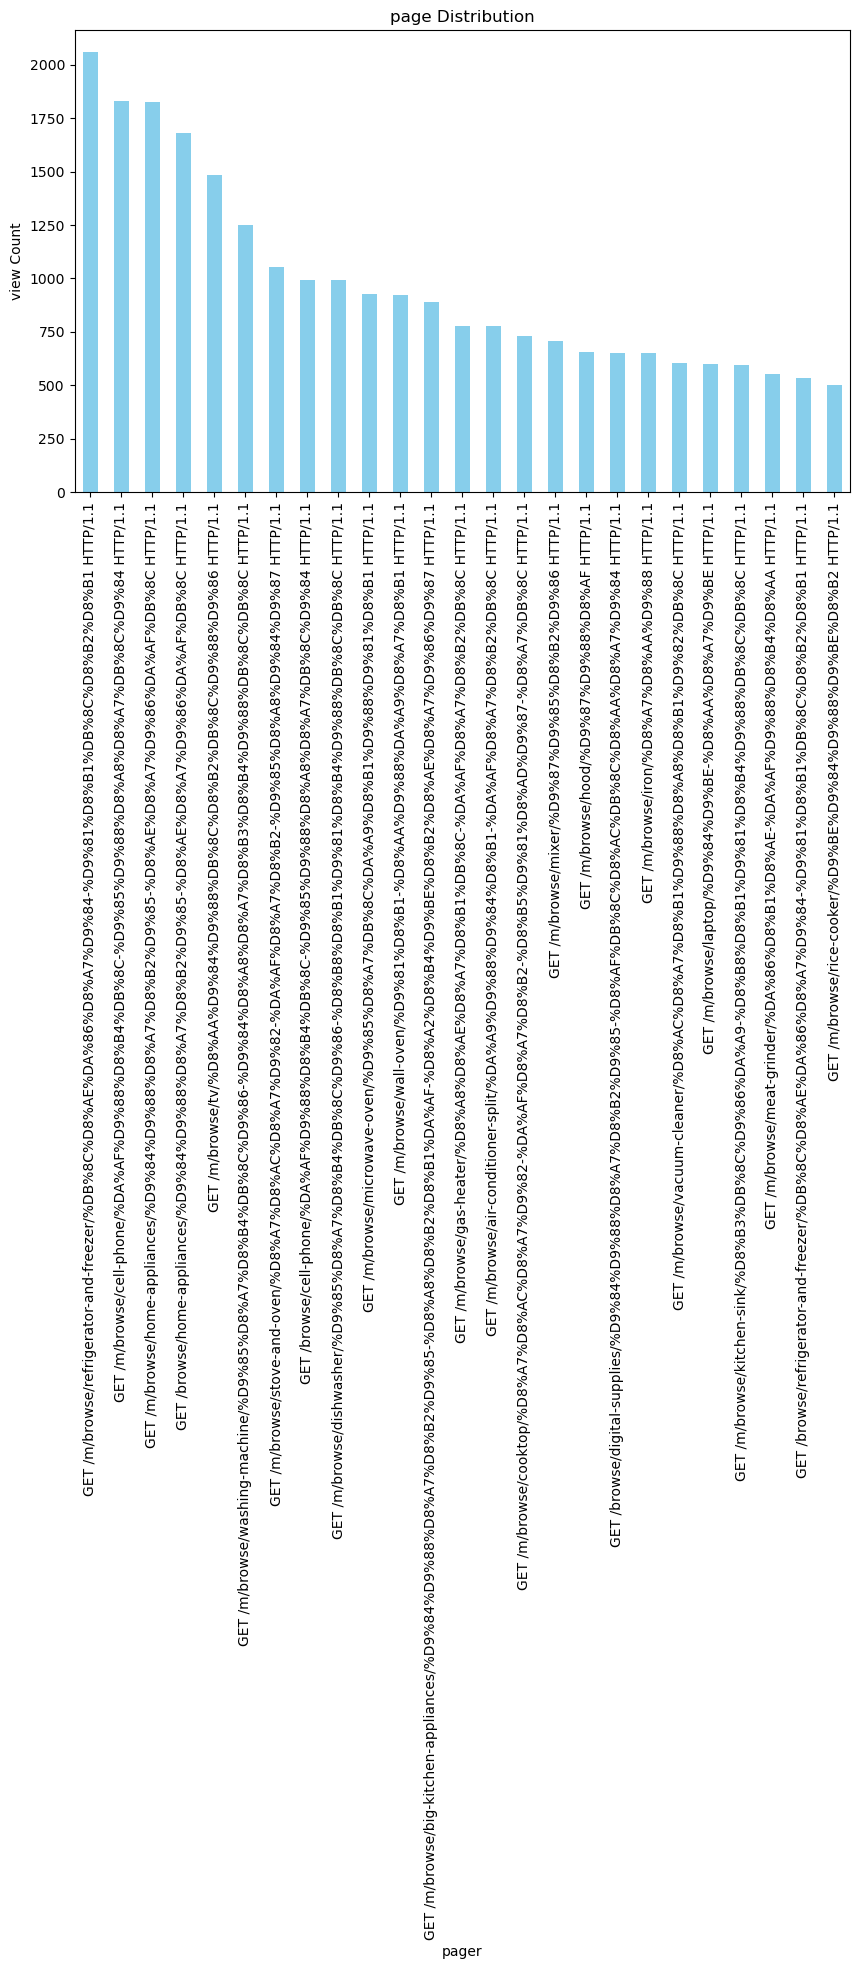

In [32]:
import matplotlib.pyplot as plt
filtered_page_view_ranking = df[df['Request'].str.contains('/browse')==True]['Request'].value_counts()
print(filtered_page_view_ranking.head(25))
# プロットを作成
plt.figure(figsize=(10, 6))
filtered_page_view_ranking.head(25).plot(kind='bar', color='skyblue')
plt.title('page Distribution')
plt.xlabel('pager')
plt.ylabel('view Count')
plt.show()

# ページごとの平均滞在時間


In [ ]:
from datetime import datetime

def conv_dt_to_milli(date_str):
    date_obj = datetime.strptime(date_str, '%d/%b/%Y:%H:%M:%S %z')
    timestamp = date_obj.timestamp()
    milliseconds = timestamp * 1000
    return milliseconds
df_zanbil_referrer = df[df['Referer'].str.contains('www.zanbil.ir', na=False)]
def get_duration(record):
    recordTime = conv_dt_to_milli(record['DateTime'])
    recentry_DateTime = None
    same_to_referers = df_zanbil_referrer[df_zanbil_referrer['Request'].str.contains(record['Referer'])]
    for same_to_referer in same_to_referers.itertuples():
        same_to_referer_milli = conv_dt_to_milli(same_to_referer.DateTime)
        if recordTime > same_to_referer_milli and (recentry_DateTime == None or recentry_DateTime < same_to_referer_milli):
            recentry_DateTime = same_to_referer_milli
    if recentry_DateTime == None:
        return 0
    else:
        return recordTime - recentry_DateTime
# IPごとにリファラがzanbil.irだった場合のページごとの滞在時間を計算
page_stay_time = df_zanbil_referrer.apply(get_duration, axis=1)
page_stay_time = page_stay_time[page_stay_time != 0]
page_stay_time = page_stay_time.mean()
print(page_stay_time)

### ユーザーが使用するデバイスの解析

UserAgent
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                         401401
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                        374133
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                                     360036
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                                                            306927
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                         

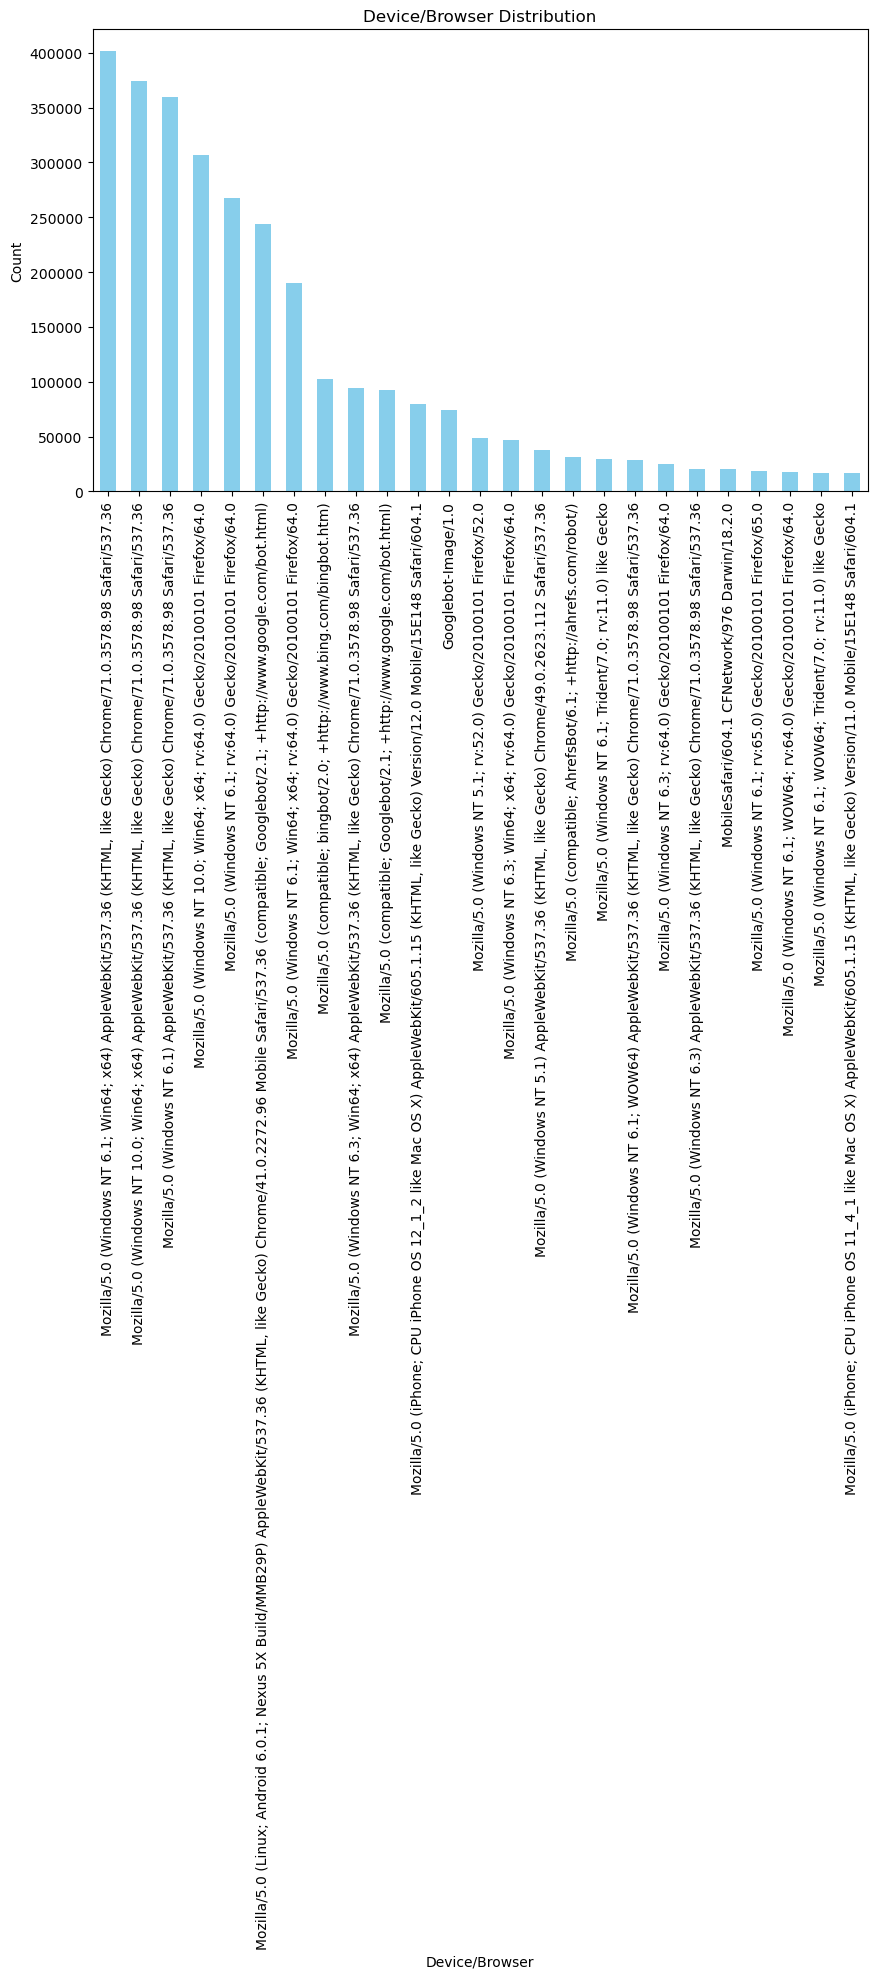

In [30]:
import matplotlib.pyplot as plt
# デバイスやブラウザの分布データを取得
device_distribution = df['UserAgent'].value_counts()

print(device_distribution[:25])
# プロットを作成
plt.figure(figsize=(10, 6))
device_distribution.head(25).plot(kind='bar', color='skyblue')
plt.title('Device/Browser Distribution')
plt.xlabel('Device/Browser')
plt.ylabel('Count')
plt.show()

### ユーザーの地域の特定

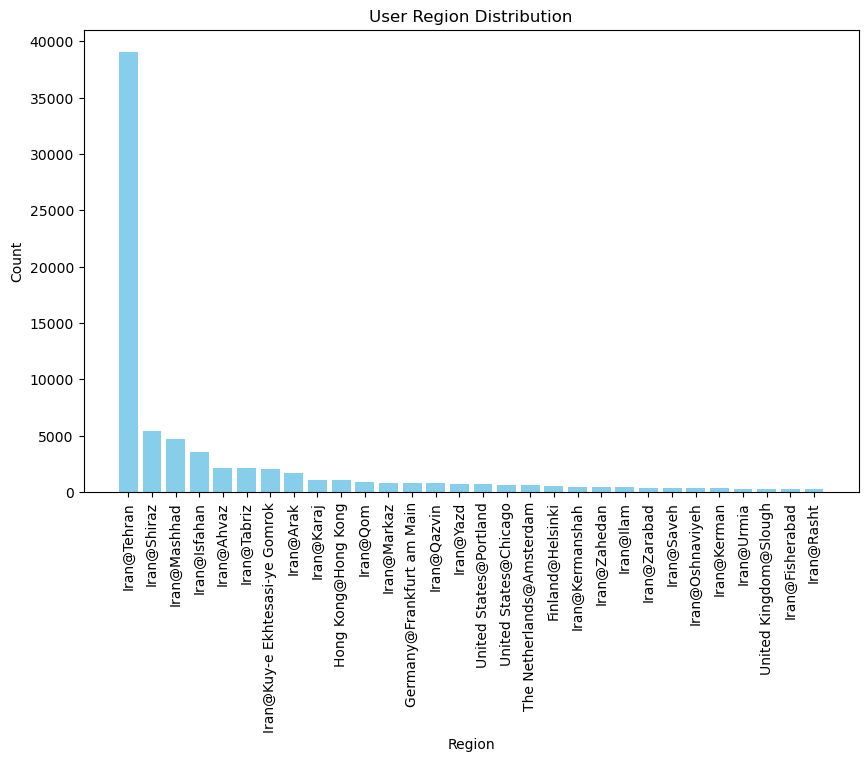

In [29]:
from itertools import islice
import geoip2.database
import numpy as np
reader = geoip2.database.Reader('data/GeoLite2-City.mmdb')
# ユニークなIPアドレスの地域を特定する
unique_ips = df['IP'].unique()
array=[]
for ip in unique_ips:
    try:
        city=reader.city(ip)
        array.append(city.country.name +'@'+city.city.name)
    except Exception as e:
        pass
region_counts = {}
for region in array:
    if region in region_counts:
        region_counts[region] += 1
    else:
        region_counts[region] = 1

sorted_regions = dict(sorted(region_counts.items(), key=lambda item: item[1], reverse=True)[:30])
# プロットを作成
plt.figure(figsize=(10, 6))
plt.bar(sorted_regions.keys(), sorted_regions.values(), color='skyblue')
plt.title('User Region Distribution')
plt.xlabel('Region')
plt.xticks(rotation=90) 
plt.ylabel('Count')
plt.show()

## 流入経路
ユーザーがどういった経路でこのサイトにたどり着いたのかを示すリファラのランキングです  
ただし、リファラが空白のものは除外します。

### zanbil.irのページABC分析
このウェブサイトへの流入元のなかで、ほとんどを占めていた、zanbil.irというウェブサイトのうち、具体的にどのページからアクセスしてきているのか。
zanbil.irトップ30件をABC分析します

30/14303
Referer_not_Zanbil
https://www.garda.ir/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C-%D9%88-%D8%A2%D8%B4%D9%BE%D8%B2%D8%AE%D8%A7%D9%86%D9%87/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%A2%D8%B4%D9%BE%D8%B2%DB%8C/%D9%BE%D8%AE%D8%AA-%D9%88-%D9%BE%D8%B2/%D9%BE%D9%84%D9%88%D9%BE%D8%B2-%D9%88-%D8%A2%D8%B1%D8%A7%D9%85-%D9%BE%D8%B2/%D9%BE%D9%84%D9%88%D9%BE%D8%B2-%D9%88-%D8%A2%D8%B1%D8%A7%D9%85-%D9%BE%D8%B2-%D9%81%D9%84%D8%B1/%D9%BE%D9%84%D9%88%D9%BE%D8%B2-%DA%86%D9%86%D8%AF%DA%A9%D8%A7%D8%B1%D9%87-%D9%81%D9%84%D8%B1-%D9%85%D8%AF%D9%84-RC96D-210944                                                                                                                                                                                                                                                                                                                                                                                                                                                     

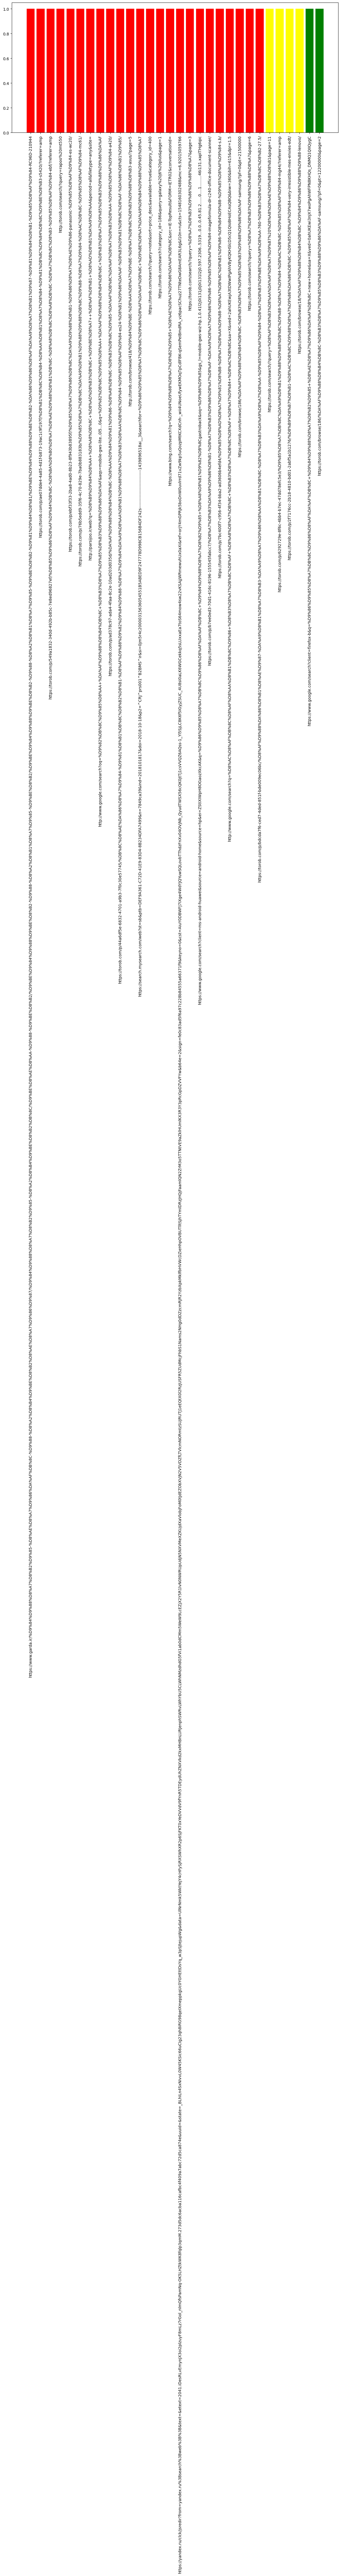

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os
# マジックコマンド
%matplotlib inline
filter_size=30
print(str(filter_size)+"/"+str(len(referer_not_zanbil_counts)))
referer_counts_top30=referer_not_zanbil_counts.tail(30)
# 頻度の累積比率を計算
cumulative_ratio = referer_counts_top30.cumsum() / referer_counts_top30.sum()

# ABC分析の閾値を設定
A_threshold = 0.8
B_threshold = 0.95

# ABCカテゴリを割り当て
categories = pd.cut(cumulative_ratio, bins=[0, A_threshold, B_threshold, 1], labels=['A', 'B', 'C'])

# 結果を表示
print(categories.tail(30))

# プロットを作成
plt.figure(figsize=(15, 6))
plt.bar(referer_counts_top30.index, referer_counts_top30.values, color=categories.map({'A': 'red', 'B': 'yellow', 'C': 'green'})) # type: ignore
plt.xticks(rotation=90)
images_directory = './images/'
try:   
    os.makedirs(images_directory)
except:
    pass
plt.savefig('./images/ABC.png')
plt.show()


30/267
Referer_Domain
torob.com                                  A
www.google.com                             B
emalls.ir                                  B
api.torob.com                              B
ptcnovin.com                               B
com.google.android.googlequicksearchbox    B
www.garda.ir                               B
irantradeco.ir                             B
www.angabin.ir                             C
www.samsungcenter.ir                       C
matching.torob.com                         C
www.ask.ir                                 C
www.mobile.ir                              C
www.bing.com                               C
www.khanesazan.com                         C
www.asire20.ir                             C
www.ptcnovin.com                           C
gahar.ir                                   C
www-isna-ir.cdn.ampproject.org             C
arzoonyab.com                              C
www.mojazsima.ir                           C
bpm.shaparak.ir                  

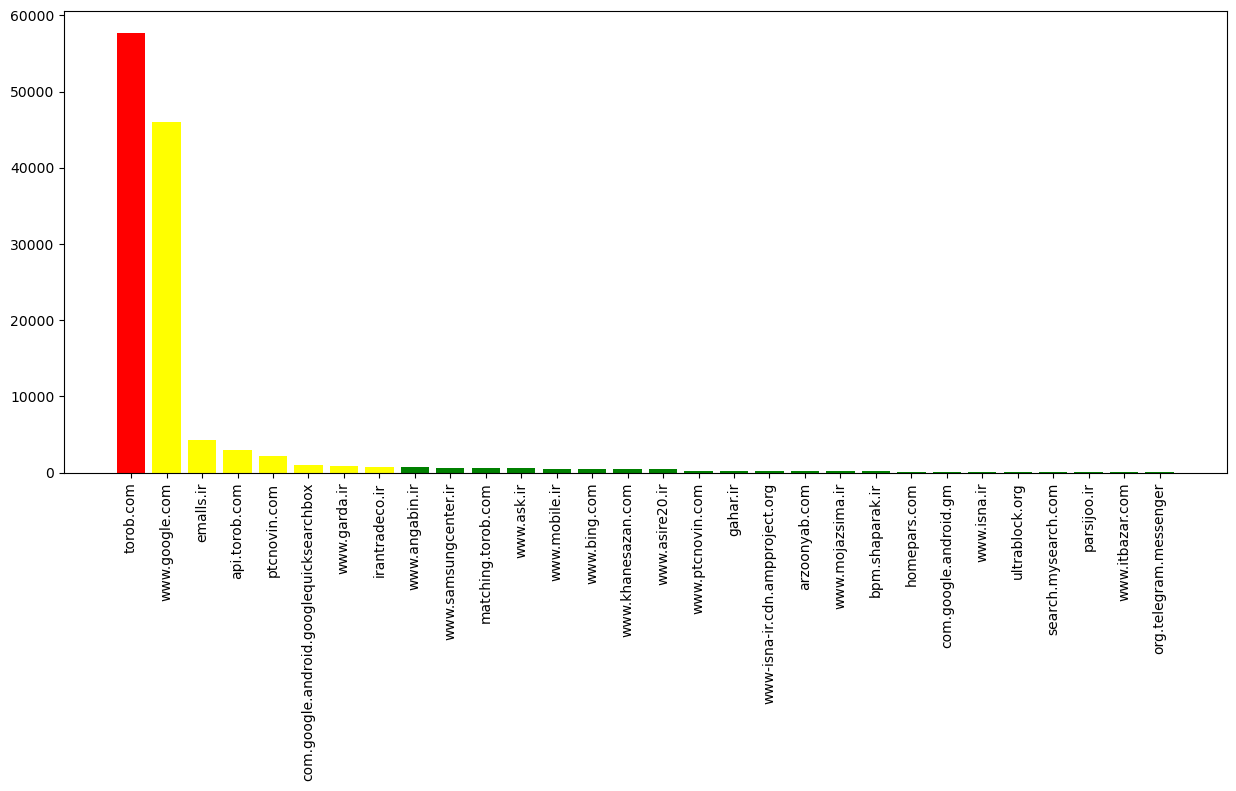

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os
# マジックコマンド
%matplotlib inline
filter_size=30
print(str(filter_size)+"/"+str(len(referer_domain_counts)))
referer_counts_top30=referer_domain_counts.head(30)
# 頻度の累積比率を計算
cumulative_ratio = referer_counts_top30.cumsum() / referer_counts_top30.sum()

# ABC分析の閾値を設定
A_threshold = 0.8
B_threshold = 0.95

# ABCカテゴリを割り当て
categories = pd.cut(cumulative_ratio, bins=[0, A_threshold, B_threshold, 1], labels=['A', 'B', 'C'])

# 結果を表示
print(categories.head(30))

# プロットを作成
plt.figure(figsize=(15, 6))
plt.bar(referer_counts_top30.index, referer_counts_top30.values, color=categories.map({'A': 'red', 'B': 'yellow', 'C': 'green'})) # type: ignore
plt.xticks(rotation=90)
images_directory = './images/'
try:   
    os.makedirs(images_directory)
except:
    pass
plt.savefig('./images/ABC_domain.png')
plt.show()
